# Collaboration and Competition - Report

## 1. Implementation Details
The implementation consists of files agent.py, model.py and ddpg_trainer.py found under the ddpg/ folder. The code is organized as follows:

`agent.py` contains code for the agent.

`model.py` contains the neural network code that is used by the agent.

`ddpg_trainer.py` contains code that is used to train the agent.
For information about the project and the environment can be found in the file `README.md`.

## 2. Algorithm
I re-used the Deep Deterministic Policy Gradient (DDPG)-code from Project 2 in the Udacity Deep Reinforcement Learning course as this was sufficient to solve this environment easily. The original code template implementing the DDPG-algorithm from the Udacity course Deep Reinforcement Learning was used as the starting point of Project 2 and hence also this Project. My work extended the template provided by Udacity by 

1. Collecting experiences from multiple agents (as there are two agents in the environment). 
2. Using different neural networks for the Actor and Critic, including Batch Normalization.

The local and target networks were initialized using the same weights (one set of weights for Actor networks and one for the Critic networks). Also I did not use Ornstein-Uhlenbeck noise for the actions.

As the agents in this environment have the same task of keeping the ball in play, and their observations are local, we will be using the same actor network for choosing actions for both of the Agents. The Critic network is naturally shared, too. Considering this setup, the DDPG where each agent adds its experience to the replay buffer is enough to

### Learning process
The algorithm uses two neural networks, the Actor that learns the optimal policy, and the Critic that learns the Q-function. The algorithm implements this as 4 neural networks, by having a local and a target network for both the Actor and Critic to stabilize learning.

The networks are training using collected (s,a,r,s') experience tuples from 20 agents, that are stored into a replay buffer. At regular intervals, we train the model by sampling tuples from the replay buffer and applying gradient based updates to the network weights. For more details see the further reading-section.

### Agent hyperparameters
| parameter                                     | value |
|-----------------------------------------------|-------|
| experience replay buffer size                 | 1e5   |
| minibatch size                                | 128   |
| gamma (discount factor)                       | 0.999 |
| tau (for soft update of target networks)      | 1e-3  |
| learning rate Actor                           | 2e-4  |
| learning rate Critic                          | 2e-4  |
| L2 weight decay (for optimizers)              | 0     |
| update_every (steps between networks updates) | 1     |
| update_times (number of consecutive/step)     | 1     |

### Neural network architecture

#### Actor
We used a neural network with 2 fully connected layers with ReLU activation and 128 hidden units. For the output layer we used tanh activation to scale the outputs to range (-1,1). We also applied Batch Normalization to the output of the first hidden layer.

#### Critic
Here we use again a neural network with 2 fully connected layers with ReLU activation and 128 hidden units. The first hidden layer takes the states as inputs. After applying non-linearity after after the 1st hidden layer, we concatenate the actions to the layer that feeds into the 2nd hidden layer. We applied Batch Normalization to the output of the first hidden layer (before we concatenate the actions, refer to the code in `model.py`).

We don't use activation function for the output layer as we are learning a Q-function.


### Further reading
[Continuous control with deep reinforcement learning (original paper on DDPG)](https://arxiv.org/pdf/1509.02971.pdf)

## 3. Training
Below we train the model until the environment is solved or max 3000 iterations. The environment is solved in 1158 iterations, after which we train it further 200 iterations to see if we can get better performance than what is required as the solving criterion. 

We are forcing CPU computation in our implementation as we saw it trained faster for these small network architectures. If you want to run on a GPU instead, uncomment the line `torch.device("cuda:0" if torch.cuda.is_available() else "cpu")` in `agent.py`. 

If you want to watch a trained agent play, skip to part 4.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg.agent import Agent
from ddpg.ddpg_trainer import train_ddpg

In [3]:
# get handle to the environment
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=True)[brain_name]
brain = env.brains[brain_name]
states = env_info.vector_observations

# environment metadata
action_size = brain.vector_action_space_size
state_size = states.shape[1]

In [5]:
print("Action size: {}".format(action_size))
print("State size: {}".format(state_size))

Action size: 2
State size: 24


In [6]:
# create the agent
agent = Agent(state_size, action_size, random_seed=1234)

In [7]:
# Train the agent for max 3000 episodes
scores = train_ddpg(agent, env, n_episodes=3000, max_t=2000, save=True)

Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.00	Score: 0.00
Episode 300	Average Score: 0.02	Score: 0.00
Episode 400	Average Score: 0.01	Score: 0.00
Episode 500	Average Score: 0.00	Score: 0.00
Episode 600	Average Score: 0.03	Score: 0.00
Episode 700	Average Score: 0.03	Score: 0.00
Episode 800	Average Score: 0.07	Score: 0.00
Episode 900	Average Score: 0.08	Score: 0.10
Episode 1000	Average Score: 0.10	Score: 0.10
Episode 1100	Average Score: 0.14	Score: 0.20
Episode 1158	Average Score: 0.50	Score: 2.60
Environment solved in 1158 episodes!

Episode 1200	Average Score: 1.27	Score: 0.20
Episode 1300	Average Score: 1.74	Score: 0.10
Episode 1357	Average Score: 1.55	Score: 0.10

In [8]:
env.close()

### 3.1 Plot of training rewards
The blue line shows the score (maximum over the agents) per episode, the orange line the average of 100 consecutive episodes, and the red horizontal line indicates the criterion used for solving (i.e. +0.5). 

In [11]:
import pandas as pd

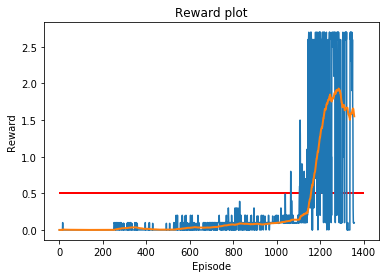

In [18]:
plt.plot(scores)
plt.plot(pd.Series(scores).rolling(100, min_periods=1).mean(), linewidth=2)
plt.hlines(y=0.5, xmin=0, xmax=1400, linewidth=2, color='r')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward plot")
plt.show()

## 4. Watch the agent play (with pretrained model)

In [23]:
# imports
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg.agent import Agent


# get handle to the environment (with graphics)
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe", no_graphics=True)

brain_name = env.brain_names[0]
env_info = env.reset(train_mode=True)[brain_name]
brain = env.brains[brain_name]
states = env_info.vector_observations

# environment metadata
action_size = brain.vector_action_space_size
state_size = states.shape[1]
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [24]:
# create the agent
agent = Agent(state_size, action_size, random_seed=1234)

# load saved model weights (load last checkpoint as it had best average results)
agent.actor_local.load_state_dict(torch.load("saved_models/best_actor.pth"))
agent.critic_local.load_state_dict(torch.load("saved_models/best_critic.pth"))

In [25]:
# Watch agent play
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
agent_scores = np.zeros(2) # initialize the scores
agent.reset()

# default brain
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        states = next_states
        agent_scores += rewards
        if np.any(dones):
            break

    
print("Score: {}".format(np.max(agent_scores)))
# close the env
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Score: 2.600000038743019


## 5. Future work
The DDPG algorithm seemed to work quite well with the same hyperparameters and network architectures as in Project 2. Also the play of the agents looks quite good. I noticed the rate of convergence varied a bit over different runs, where the environment was usually solved still under 2000 episodes. Thus I think most of the work could be done in optimizing the convergence of the algorithm, even though the wall time used for solving the environment was not too much. Also, still late in training some low scores are gained on individual runs.

A few concrete ideas for future work include again prioritized experience replay and more thorough hyperparameter search could be used for this purpose. Also it would be interesting to try a different algorithm such as [PPO](https://arxiv.org/pdf/1707.06347.pdf), [A3C](https://arxiv.org/pdf/1602.01783.pdf) or [D4PG](https://openreview.net/pdf?id=SyZipzbCb).